# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [2]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [3]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [4]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [5]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='./toxiccomments_train.csv', my_random_seed=70)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [13]:
from sklearn import linear_model
from sklearn.svm import SVC, LinearSVC
# ols = linear_model.SGDClassifier(loss="squared_loss")
ols = LinearSVC(C=1)
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'c=1_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12904, 'TN': 114443, 'FP': 219, 'FN': 90, 'Accuracy': 0.9975794322241023, 'Precision': 0.9833117427417511, 'Recall': 0.9930737263352316, 'desc': 'c=1_train'}


/Users/zyq/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### MODEL: SVM, linear

In [14]:
from sklearn import linear_model
from sklearn.svm import SVC, LinearSVC
# svm = linear_model.SGDClassifier()
svm = LinearSVC(C=0.1)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'c=0.1_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12943, 'TN': 114564, 'FP': 98, 'FN': 51, 'Accuracy': 0.9988328006517516, 'Precision': 0.9924852388620504, 'Recall': 0.9960751115899646, 'desc': 'c=0.1_train'}


/Users/zyq/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### MODEL: logistic regression

In [16]:
from sklearn import linear_model
# lgs = linear_model.SGDClassifier(loss='log')
lgs = LinearSVC(C=100)
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'c=100_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12910, 'TN': 114397, 'FP': 265, 'FN': 84, 'Accuracy': 0.9972660901171899, 'Precision': 0.9798861480075901, 'Recall': 0.9935354779128829, 'desc': 'c=100_train'}


/Users/zyq/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### MODEL: Naive Bayes

In [17]:
from sklearn.naive_bayes import MultinomialNB
# nbs = MultinomialNB()
nbs = LinearSVC(C=1000)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'c=1000_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12921, 'TN': 114403, 'FP': 259, 'FN': 73, 'Accuracy': 0.9973992605126277, 'Precision': 0.9803490136570562, 'Recall': 0.9943820224719101, 'desc': 'c=1000_train'}


/Users/zyq/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### MODEL: Perceptron

In [18]:
from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron')
prc = LinearSVC(C=10000)
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'c=10000_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12903, 'TN': 114414, 'FP': 248, 'FN': 91, 'Accuracy': 0.997344425643918, 'Precision': 0.9811421184700784, 'Recall': 0.9929967677389564, 'desc': 'c=10000_train'}


/Users/zyq/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### MODEL: Ridge Regression Classifier

In [19]:
from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
rdg = LinearSVC(C=100000)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'c=100000_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12897, 'TN': 114385, 'FP': 277, 'FN': 97, 'Accuracy': 0.9970702513003697, 'Precision': 0.9789737361469562, 'Recall': 0.9925350161613052, 'desc': 'c=100000_train'}


/Users/zyq/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### MODEL: Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier
# rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf = LinearSVC(C=500000)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'c=500000_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12907, 'TN': 114418, 'FP': 244, 'FN': 87, 'Accuracy': 0.9974070940653005, 'Precision': 0.9814462778495932, 'Recall': 0.9933046021240572, 'desc': 'c=500000_train'}


/Users/zyq/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### ROC plot to compare performance of various models and fits

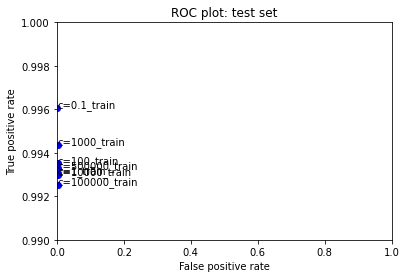

In [27]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.99, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [28]:
ols_predictions = ols.predict(X_train)

In [29]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
10808
Please review citation 62 and 63. They are both Cory Booker saying what the article says Cory Booker did. That is not objective under wikipedia standards. Sorry that I pissed you off. All I want is wikipedia to be useful. When I'm done pissing you off, I think we'll have a stronger article here.  209.162.18.52
* * * * * * * * * 
23012
"

Maybe rather stop campaigning? MY was the one to get the ""Матюки делают з тоби москаля"" Ukrainian political poster out of the article on Russophobia. I did not mind, as this was quite a minor political party in Ukraine. This one is too quite a minor TV channel in Russia, with one of the lowest ratings in the country. So no need to get exited.  "
* * * * * * * * * 
42022
Merry Christmas!
LOL! I'm a dog person myself, but what the heck, we can all get along! . . .and a Happy New Year too!
* * * * * * * * * 
43955
Thanks. I'm not used to Wikipedia, lol. I'm usually making minor edits but I saw oddly there was no Cately

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [31]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'c=1_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2210, 'TN': 26480, 'FP': 2204, 'FN': 1021, 'Accuracy': 0.8989503368322106, 'Precision': 0.5006796556411418, 'Recall': 0.683998761993191, 'desc': 'c=1_test'}


### MODEL: SVM, linear

In [32]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'c=0.1_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2233, 'TN': 27022, 'FP': 1662, 'FN': 998, 'Accuracy': 0.9166536111546295, 'Precision': 0.5732991014120667, 'Recall': 0.6911173011451563, 'desc': 'c=0.1_test'}


### MODEL: logistic regression

In [33]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'c=10_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2218, 'TN': 26222, 'FP': 2462, 'FN': 1013, 'Accuracy': 0.8911170296099012, 'Precision': 0.4739316239316239, 'Recall': 0.6864747756112659, 'desc': 'c=10_test'}


### MODEL: Naive Bayes

In [34]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'c=100_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2233, 'TN': 26196, 'FP': 2488, 'FN': 998, 'Accuracy': 0.8907723640921197, 'Precision': 0.4729930099555179, 'Recall': 0.6911173011451563, 'desc': 'c=100_test'}


### MODEL: Perceptron

In [35]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'c=1000_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2227, 'TN': 26200, 'FP': 2484, 'FN': 1004, 'Accuracy': 0.8907096976343413, 'Precision': 0.47272341328804923, 'Recall': 0.6892602909316001, 'desc': 'c=1000_test'}


### MODEL: Ridge Regression Classifier

In [36]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'c=10000_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2221, 'TN': 26219, 'FP': 2465, 'FN': 1010, 'Accuracy': 0.8911170296099012, 'Precision': 0.4739650021340162, 'Recall': 0.6874032807180439, 'desc': 'c=10000_test'}


### MODEL: Random Forest Classifier

In [37]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'c=50000_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2217, 'TN': 26186, 'FP': 2498, 'FN': 1014, 'Accuracy': 0.8899577001409995, 'Precision': 0.4702014846235419, 'Recall': 0.6861652739090065, 'desc': 'c=50000_test'}


### ROC plot to compare performance of various models and fits

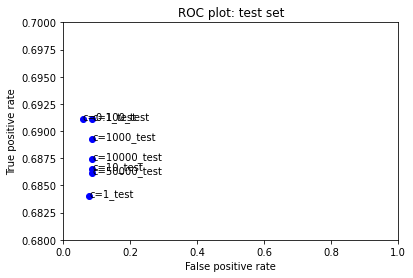

In [45]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.68, 0.7])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/toxiccomments_test.csv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.4837102713431355


In [25]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [26]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,True
2,00013b17ad220c46,False
3,00017563c3f7919a,True
4,00017695ad8997eb,True


In [27]:
my_submission.shape

(153164, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation